<a href="https://colab.research.google.com/github/AryaJeet1364/PyTorch_Projects/blob/main/CIFAR_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np

# Data augmentation for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Simple normalization for test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(f"Running on: {device}")

Running on: cuda


In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(imgs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/len(trainloader):.4f}")


Epoch [1/10] - Loss: 1.6518
Epoch [2/10] - Loss: 1.3774
Epoch [3/10] - Loss: 1.2508
Epoch [4/10] - Loss: 1.1741
Epoch [5/10] - Loss: 1.1236
Epoch [6/10] - Loss: 1.0814
Epoch [7/10] - Loss: 1.0556
Epoch [8/10] - Loss: 1.0301
Epoch [9/10] - Loss: 1.0083
Epoch [10/10] - Loss: 0.9883


In [5]:
# Training accuracy calculation
model.eval()
train_true, train_pred = [], []

with torch.no_grad():
    for imgs, labels in trainloader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        train_true.extend(labels.numpy())
        train_pred.extend(preds.cpu().numpy())

train_acc = accuracy_score(train_true, train_pred)
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")

✅ Training Accuracy: 71.00%


In [6]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in testloader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")


✅ Test Accuracy: 72.68%


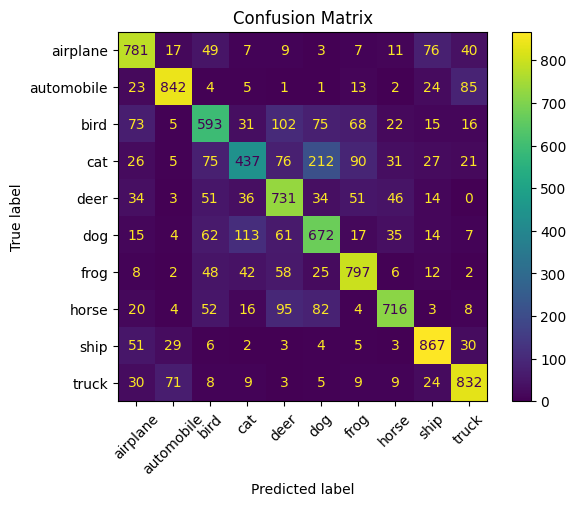

In [7]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()